
=== TOY EXAMPLE MADE (D=3, H=4) ===
Degrees input : [1 2 3]
Degrees hidden: [1 2 1 1]
Degrees output: [1 2 3]
Mask input->hidden:
 [[1. 1. 1. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
Mask hidden->output:
 [[0. 1. 1.]
 [0. 0. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]
Forward pass output probs: [[0.5 0.5 0.5]]

Training NADE...
Epoch 1/2 - loss: 0.4104
Epoch 2/2 - loss: 0.2692
Sampling NADE...


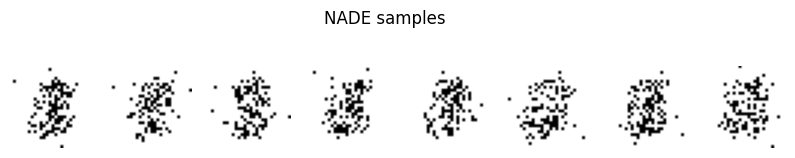


Training MADE...
Epoch 1/2 - loss: 0.6123
Epoch 2/2 - loss: 0.4733
Sampling MADE...


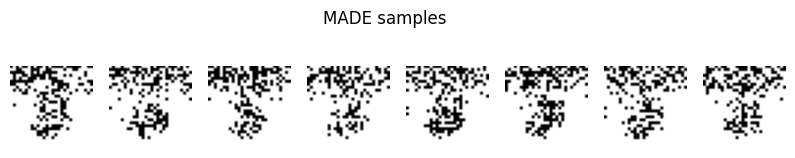

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

# --------------------------- Utilities ---------------------------

def load_binarized_mnist(train_size=5000, test_size=500):
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train / 255.0) > 0.5
    x_test = (x_test / 255.0) > 0.5
    x_train = x_train.reshape(-1, 28 * 28).astype(np.float32)
    x_test = x_test.reshape(-1, 28 * 28).astype(np.float32)
    return x_train[:train_size], x_test[:test_size]


def visualize_samples(samples, title="Samples"):
    samples = samples.reshape(-1, 28, 28)
    plt.figure(figsize=(10, 2))
    for i in range(min(8, samples.shape[0])):
        plt.subplot(1, min(8, samples.shape[0]), i + 1)
        plt.imshow(samples[i], cmap="binary")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# --------------------------- NADE (incremental) ---------------------------
class NADE(tf.keras.Model):
    """True NADE implementation: sequential autoregressive with incremental hidden updates."""

    def __init__(self, D, H):
        super().__init__()
        self.D, self.H = D, H

        # Parameters
        self.W = self.add_weight(name="W", shape=(H, D), initializer="glorot_uniform")  # visible->hidden
        self.V = self.add_weight(name="V", shape=(H, D), initializer="glorot_uniform")  # hidden->visible
        self.c = self.add_weight(name="c", shape=(H,), initializer="zeros")              # hidden bias
        self.b = self.add_weight(name="b", shape=(D,), initializer="zeros")              # output bias

    def call(self, x):
        batch_size = tf.shape(x)[0]
        a = tf.tile(self.c[None, :], [batch_size, 1])  # hidden pre-activations
        outputs = []

        for i in range(self.D):
            # hidden activation given current pre-activation
            h = tf.nn.sigmoid(a)                                # (batch,H)
            logit = tf.matmul(h, self.V[:, i:i+1]) + self.b[i]  # (batch,1)
            prob = tf.nn.sigmoid(logit)
            outputs.append(prob)

            # update hidden pre-activations with contribution from observed x_i
            a = a + tf.matmul(x[:, i:i+1], self.W[:, i:i+1], transpose_b=True)

        return tf.concat(outputs, axis=1)  # (batch,D)

    def compute_loss(self, x):
        probs = self(x)
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, probs))

    def sample(self, n_samples):
        samples = []
        a = tf.tile(self.c[None, :], [n_samples, 1])  # hidden pre-activations

        for i in range(self.D):
            h = tf.nn.sigmoid(a)                                   # (batch,H)
            logit = tf.matmul(h, self.V[:, i:i+1]) + self.b[i]     # (batch,1)
            prob = tf.nn.sigmoid(logit)

            # sample from Bernoulli
            x_i = tf.cast(tfp.distributions.Bernoulli(probs=prob).sample(), tf.float32)
            samples.append(x_i)

            # update hidden pre-activations with sampled x_i
            a = a + tf.matmul(x_i, self.W[:, i:i+1], transpose_b=True)

        return tf.concat(samples, axis=1)  # (batch,D)


# --------------------------- MADE (one hidden layer) ---------------------------
class MADE(tf.keras.Model):
    """MADE: Masked Autoencoder for Distribution Estimation (one hidden layer)."""

    def __init__(self, D, H, seed=None):
        super().__init__()
        self.D, self.H = D, H
        self.rng = np.random.RandomState(seed)

        # Degrees
        self.deg_input = np.arange(1, D + 1)       # [1..D]
        self.deg_hidden = self.rng.randint(1, D, size=H)  # hidden degrees
        self.deg_output = np.arange(1, D + 1)      # [1..D]

        # Weights
        self.W_in_hid = self.add_weight(name="W_in_hid", shape=(D, H), initializer="glorot_uniform")
        self.b_hid = self.add_weight(name="b_hid", shape=(H,), initializer="zeros")
        self.W_hid_out = self.add_weight(name="W_hid_out", shape=(H, D), initializer="glorot_uniform")
        self.b_out = self.add_weight(name="b_out", shape=(D,), initializer="zeros")

        # Masks
        # (D,H): input dim i connects to hidden j if deg_in[i] <= deg_hidden[j]
        self.mask_in_hid = (self.deg_input[:, None] <= self.deg_hidden[None, :]).astype(np.float32)
        # (H,D): hidden j connects to output i if deg_hidden[j] < deg_output[i]
        self.mask_hid_out = (self.deg_hidden[:, None] < self.deg_output[None, :]).astype(np.float32)

    def call(self, x):
        # Input -> Hidden
        h = tf.nn.relu(tf.matmul(x, self.W_in_hid * self.mask_in_hid) + self.b_hid)  # (batch,H)

        # Hidden -> Output
        out = tf.matmul(h, self.W_hid_out * self.mask_hid_out) + self.b_out  # (batch,D)
        return tf.nn.sigmoid(out)

    def compute_loss(self, x):
        probs = self(x)
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, probs))

    def sample(self, n_samples):
        samples = np.zeros((n_samples, self.D), dtype=np.float32)
        for i in range(self.D):
            probs = self(samples)[:, i]
            samples[:, i] = tfp.distributions.Bernoulli(probs=probs).sample().numpy().astype(np.float32)
        return samples

# --------------------------- Training helpers ---------------------------
def train_model(model, x_train, epochs=3, batch_size=128, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(lr)
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)
    for epoch in range(epochs):
        total_loss, n_batches = 0.0, 0
        for batch in dataset:
            with tf.GradientTape() as tape:
                loss = model.compute_loss(batch)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            total_loss += loss.numpy()
            n_batches += 1
        print(f"Epoch {epoch+1}/{epochs} - loss: {total_loss / n_batches:.4f}")

# --------------------------- Toy numerical example ---------------------------
def toy_example():
    D, H = 3, 4
    print("\n=== TOY EXAMPLE MADE (D=3, H=4) ===")
    made = MADE(D, H, seed=42)

    print("Degrees input :", made.deg_input)   # [1,2,3]
    print("Degrees hidden:", made.deg_hidden)  # e.g. [2,1,3,2]
    print("Degrees output:", made.deg_output)  # [1,2,3]

    print("Mask input->hidden:\n", made.mask_in_hid)
    print("Mask hidden->output:\n", made.mask_hid_out)

    # Dummy input x
    x = tf.constant([[1., 0., 1.]], dtype=tf.float32)  # (1,3)
    probs = made(x)
    print("Forward pass output probs:", probs.numpy())

# --------------------------- Main script ---------------------------
if __name__ == '__main__':
    tf.random.set_seed(0)
    np.random.seed(0)

    # Run toy example first
    toy_example()

    # Train on MNIST
    D = 28 * 28
    x_train, x_test = load_binarized_mnist(train_size=2000, test_size=200)

    # NADE
    print("\nTraining NADE...")
    nade = NADE(D=D, H=400)
    train_model(nade, x_train, epochs=2, batch_size=128, lr=1e-3)

    print("Sampling NADE...")
    samples_nade = nade.sample(8).numpy()
    visualize_samples(samples_nade, title="NADE samples")

    # MADE
    print("\nTraining MADE...")
    made = MADE(D=D, H=400, seed=2)
    train_model(made, x_train, epochs=2, batch_size=128, lr=1e-3)

    print("Sampling MADE...")
    samples_made = made.sample(8)
    visualize_samples(samples_made, title="MADE samples")